In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
plt.rc('font', size=14)

### Cell growth (logistic growth)
\begin{align}
\text{ODE:}&& \frac{dr}{dt} &= kr(r^*-r), \\
\text{Initial condition:}&& r(t_0) &= r_0
\end{align}

This equation can be solved analytically, there is no need for a numerical solution

$$\Longrightarrow \quad r(t) = r^* - e^{-k(t-t_0)}(r^* - r_0)$$

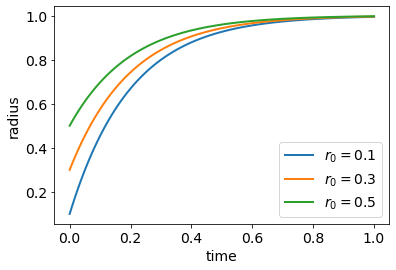

In [2]:
def radiusGrowth(k, t, t0, r0, r_max):
    return r_max - np.exp(-k*(t-t0))*(r_max - r0)

t = np.linspace(0,1,100)
plt.plot(t, radiusGrowth(5, t, t[0], 0.1, 1), lw = 2, label = '$r_0=0.1$')
plt.plot(t, radiusGrowth(5, t, t[0], 0.3, 1), lw = 2, label = '$r_0=0.3$')
plt.plot(t, radiusGrowth(5, t, t[0], 0.5, 1), lw = 2, label = '$r_0=0.5$')
plt.xlabel('time')
plt.ylabel('radius')
plt.legend()

### Cell Division

We define a probability that a cell undergoes division depending on its radius.

Text(0, 0.5, 'probability')

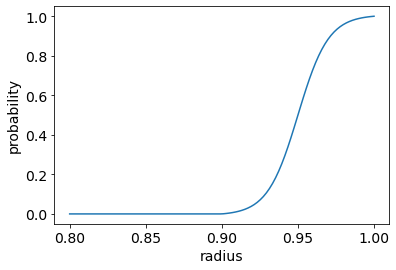

In [3]:
def divisionProbability(r, r_max):
    c = 100/r_max
    y = 0.95*r_max
    r_min = 0.9*r_max
    b = (1 + np.exp(c*(r_max-y)))*(1 + np.exp(c*(r_min-y)))/(np.exp(c*(r_min-y)) - np.exp(c*(r_max-y)))
    a = -b/(1 + np.exp(c*(r_min-y)))
    P = a+b/(1 + np.exp(c*(r-y)))

    return np.maximum(0, P)

r = np.linspace(0.8, 1, 100)
plt.plot(r, divisionProbability(r, 1))
plt.xlabel('radius')
plt.ylabel('probability')

In [4]:
A = np.array([[1,1],[2,2]])
print(A)
print(A.T)

[[1 1]
 [2 2]]
[[1 2]
 [1 2]]


In [5]:
def cellDivision(xy, r, r0, r_old, r_max, t, t0):

    P0 = divisionProbability(r_old, r_max)       
    P = divisionProbability(r, r_max)

    Prob = (P-P0)/(1-P0)
    Prob[r_old == r0] = P[r_old == r0]
    
    # Choose where division will randomly occur
    random_numbers = np.random.rand(len(r))
    indices = np.where(random_numbers < Prob)
    
    # New radius based on the area of the mother cell being two times that of the daughter cells
    # Use volume in 3D instead
    r_new = r[indices]/2**(1/2)
    
    # Distance between the two daughter cells
    dist = np.random.normal((r[indices] - r_new)/2, 0.1*(r[indices] - r_new)/2)
    
    # Angles of cell division
    angle = np.random.rand(len(r[indices]))*2*np.pi
    
    # Displacement vectors
    dx = dist*np.cos(angle)
    dy = dist*np.sin(angle)
    
    # Displacement
    dxy = np.array([dx,dy]).T
    xy1 = xy[indices] + dxy
    xy2 = xy[indices] - dxy
    
    # Change x-y-position to new value and add new cell to array
    xy[indices] = xy1
    xy = np.append(xy, xy2, axis=0)
    
    # Update radii and include radii for new cells
    r[indices] = r_new
    r = np.append(r, r_new)
    
    # Change initial radius to value directly after division and include new cells to array
    r0[indices] = r_new
    r0 = np.append(r0, r_new)

    # Change initial radius to value directly after division and include new cells to array
    t0[indices] = t
    t0 = np.append(t0, t0[indices])
    return xy, r, r0, t0

Text(0.5, 1.0, 'after')

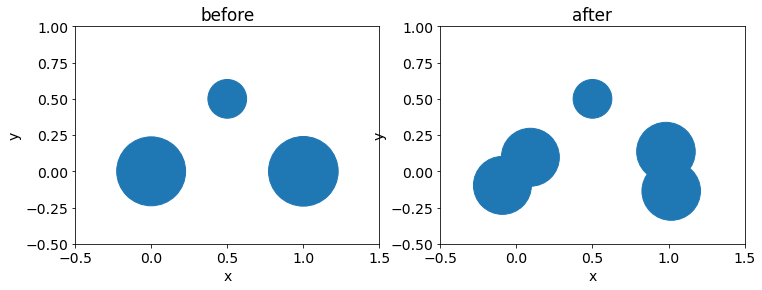

In [6]:
# Test with 3 cells
xy = np.array([[0,0], [1,0], [0.5,0.5]])
r = np.array([0.95, 0.97, 0.3])
r_old = np.array([0.92, 0.95, 0.2])
r0 = np.array([0.5, 0.5, 0.5])
t = 1
t0 = np.zeros(len(r0))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(xy[:,0], xy[:,1], s=r*5000)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('before')

# Function call
xy, r, r0, t0 = cellDivision(xy, r, r0, r_old, 1, t, t0)

plt.subplot(122)
plt.scatter(xy[:,0], xy[:,1], s=r*5000)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('after')

### Displacement
The cell position changes depending on the sum of the forces acting on each cell, i.e.

$$\frac{dx_i}{dt} = \sum_{j \neq i} F_{ij}$$

The force in this special case is given by the derivative of the Morse potential

$$F_{ij} = 2 F_0 \left(e^{-\alpha(||x_i-x_j|| - \sigma(r_i+r_j))} - e^{-2\alpha(||x_i-x_j|| - \sigma(r_i+r_j))}\right)\frac{x_i - x_j}{||x_i - x_j||}$$

In [7]:
a = np.array([1,2,3])
b = np.reshape(a, [len(a), 1])

print(a + b)

[[2 3 4]
 [3 4 5]
 [4 5 6]]


In [8]:
def forces(xy, r, F0, α, σ):
    # α is the stiffness
    # σ determines where the cells are ideally positioned in terms of their radii
    # F0 is a scaling factor
    
    dist = cdist(xy, xy)
    rT = np.reshape(r,[len(r),1])
    x = xy[:,0]
    y = xy[:,1]
    xT = np.reshape(x,[len(x),1])
    yT = np.reshape(y,[len(y),1])
    
    # Pairwise sum of radii and difference of coordinates
    r_pairwise = r + rT
    x_pairwise = x - xT
    y_pairwise = y - yT
    
    # Absolute values of forces according to Morse potential
    F = F0*2*α*(np.exp(-2*α*(dist-r_pairwise*σ)) - np.exp(-α*(dist-r_pairwise*σ)))
    #F[dist > r_pairwise] = 0

    # Fill distance matrix with inf on diagonal
    np.fill_diagonal(dist, np.inf)
    
    # x- and y-direction of forces
    Fx = F*(x_pairwise)/dist
    Fy = F*(y_pairwise)/dist
    
    # Sum of all forces acting on each cell as a vector
    Force = np.array([np.sum(Fx, axis=1), np.sum(Fy, axis=1)]).T
    
    return Force

In [9]:
def displacement(xy, r, dt, F0, α, σ):
        F = forces(xy, r, F0, α, σ)
        xy = xy - dt*F

        return xy

[[0.         1.80000893 1.799996  ]
 [1.80000893 0.         1.79999505]
 [1.799996   1.79999505 0.        ]]


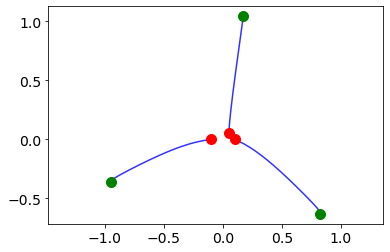

In [10]:
# Test for a few timesteps and 3 cells
xy = np.array([[-0.1,0], [0.1,0], [0.05,0.05]])
r = np.array([1, 1, 1])

N = 3000
dt = 0.001

txy = np.empty([N, xy.shape[0], xy.shape[1]])
txy[0,:,:] = xy
for i in range(N-1):
    txy[i+1,:,:] = displacement(txy[i,:,:], r, dt, 1, 1, 0.9)

# Plot starting and end point of each cell together with its path
for i in range(txy.shape[1]): 
    plt.plot(txy[:,i,0],txy[:,i,1], 'b', alpha = 0.8)
    plt.plot(txy[0,i,0],txy[0,i,1], 'ro', ms = 10)
    plt.plot(txy[-1,i,0],txy[-1,i,1], 'go', ms = 10)

plt.axis('equal')

# Check if pairwise distances are in equilibrium at σ*(r_i + r_j)
print(cdist(txy[-1,:,:],txy[-1,:,:]))

In [16]:
def cellPlot(xy, r, size = 2, alphaValue=1,xLimVector=[-10,10],yLimVector=[-10,10]):        
                
        nofCells = len(xy)
        #### plot cell nuclei ####
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111, aspect='equal')
        ax1.scatter(xy[:,0],xy[:,1], color='k', s=size, zorder=2)
      
        #### plot cells as circle  ####
        for i in range(nofCells):
            (xPosition,yPosition)=xy[i]
            radius=r[i]
            ax1.add_patch(plt.Circle((xPosition,yPosition), radius,alpha=alphaValue))
            
        plt.xlim(xLimVector)
        plt.ylim(yLimVector)
        plt.axis('off')
        return

### Combine everything
Iterate over a certain timeframe and for every timestep follow the same procedure
- Update time
- Update radii
- Let cells divide
- Update cell position

0.7597527503967285


<Figure size 432x432 with 0 Axes>

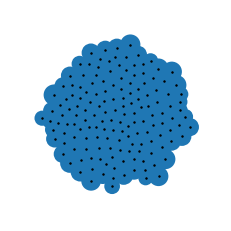

In [17]:
from time import time

tic = time()
T = 24                   # Time
N = 3000                 # Number of timesteps
t = np.linspace(0,T,N)   # Time at each timestep
dt = t[1]-t[0]           # timestep
r_max = 1                # Maximum radius
k = 0.5                  # Cell growth rate
F0 = 0.1                 # Force scaling
α = 3                    # Cell stiffness
σ = 0.7                  # Don't know how to call that one

# Initial conditions
xy = np.array([[-0.1,0], [0.1,0], [0.05,0.05]])
r = np.array([0.4, 0.5, 0.7])
r0 = r
t0 = np.zeros(len(r))

for i in range(N):
    r_old = r
    r = radiusGrowth(k, t[i], t0, r0, r_max)
    xy, r, r0, t0 = cellDivision(xy, r, r0, r_old, r_max, t[i], t0)
    xy = displacement(xy, r, dt, F0, α, σ)
    
toc = time()
print(toc-tic)
# Final state
plt.figure(figsize=(6,6))
cellPlot(xy, r)